In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Data Loading from CSV

This notebook shows how to load and prepare data into the machine-learning pipeline with ``AUCMEDI``.  
``AUCMEDI`` provides functions to load data from ``directory``, from ``csv`` and from ``json``.  

Here, we will load the data from disc and the labels from ``csv``.  
But the data first need to be downloaded from the web.

## Downloading the data

In [2]:
cwd = !pwd
datadir = cwd[0] + "/data"

from pathlib import Path

Path(datadir).mkdir(parents=True, exist_ok=True)

#import wget

#print('Beginning file download with wget module')

#url = 'https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1'
#wget.download(url, datadir)

# unzip the data

#import zipfile
#with zipfile.ZipFile("data/Kather_texture_2016_image_tiles_5000.zip","r") as zip_ref:
#    zip_ref.extractall("data")

Now we have downloaded our data and unzipped them.  
The way these data come, pictures of each class are in stored in a seperate folder, like so:

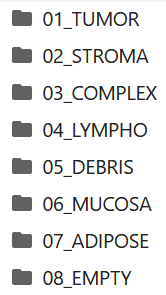

This means, since the images of different categories are saved in different folders we could directly infer the labels from the directory names.  
Aucmedi has the ``directory``-io-pipeline for this purpose. It is explained in another notebook.

But here we want to assume that our data are all in one folder and the labels are stored in a corresponding csv-file, because sometime data come in this format.  

Fortunatly ``AUCMEDI`` provides an input-pipeline for this purpose aswell, the csv-io-pipeline.  

However, our data are not all in one folder and we don't have a csv-file with the labels/annotations.  
So we need to prepare that.  

There are basically two options how the annotations could be saved in the csv, they could be encoded as sparse categorical classes or as One-Hot encoded classes.  

If the annontations are encoded as sparse categorical classes the csv-file looks like this:

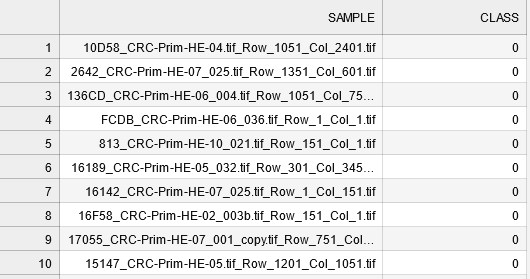

The names of the samples are encoded in a column called ``SAMPLE`` (default, it can be changed, if it's different in your annotations-csv) and the sparse categorical labels are stored in a column called ``CLASS`` (again, just the default).  
The labels can be integers or strings.  

So lets quickly create such an annotation-csv, since we don't have one for this dataset.  

First we'll copy all data in one folder, because we will get the labels from the csv and not from the directory-structure. At the same time we are saveing the label-information for each image in a dictionary (``image_dict``).

In [ ]:
import shutil
import os

target_dir = cwd[0] + '/alldata'
Path(target_dir).mkdir(parents=True, exist_ok=True)

arr = os.listdir(datadir + '/Kather_texture_2016_image_tiles_5000')

image_dict = {}

for i in range(len(arr)):
    source_dir=datadir + '/Kather_texture_2016_image_tiles_5000/' + arr[i]
    file_names = os.listdir(source_dir)
    for file_name in file_names:
        if file_name.endswith(".tif"): 
            image_dict[file_name] = arr[i]
            shutil.copy(os.path.join(source_dir, file_name), target_dir)

Next we convert the ``image_dict`` (which as the label information for each image stored) to a pandas ``dataframe`` and then to ``csv``.

In [4]:
import pandas as pd

df = pd.DataFrame.from_dict(data=image_dict, orient='index', columns=['CLASS'])
df.index.name = 'SAMPLE'
df.reset_index(inplace=True)
df.to_csv(r'labels.csv', index = False, header=True)

So now we finally have a csv-file that contains the image-names and the corresponding labels:  
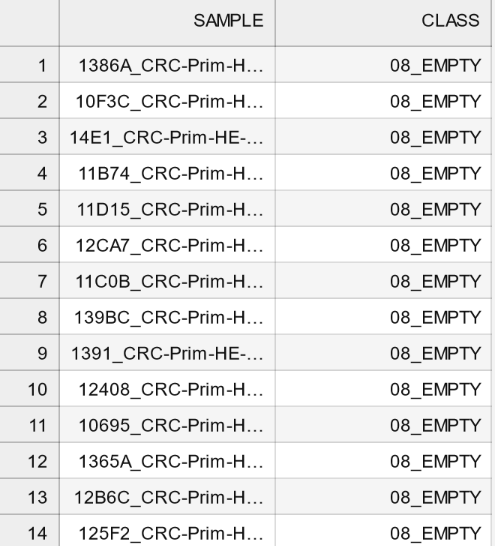

## Loading the data into aucmedi

To load the data, we are using the ``input_interface`` from ``AUCMEDI``. It enables you to load data and the corresponding annotations from ``directory``, from ``csv``, or from ``json``.  
Here, we are going to use ``csv`` as the interface. Therefore we have to tell ``AUCMEDI``, where the images are (``path_imagedir``) and where the annotations are (``path_data``) and whether the annotations are One Hot Encoded or not (``ohe``, default=``True``).  
Since we wrote sparsely encoded labels in our annotation file, ``ohe=False`` in our case.  
Optionally, or if we wouldn't use the defaults, we tell ``AUCMEDI`` in which column the sample-names can be found (``col_sample``) and in which column the spasely encoded labels are (``col_class``).

In [5]:
from aucmedi.data_processing import io_data
ds_loader = io_data.input_interface(interface="csv", path_imagedir="alldata", 
                                    path_data="labels.csv", training=True, ohe=False,
                                    col_sample="SAMPLE", col_class="CLASS")
(samples, class_ohe, nclasses, class_names, image_format) = ds_loader

2022-07-20 11:58:21.742131: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


That's it!

Now you might wonder how the ``input_interface`` could be used if we used One Hot Encoded labels.  

First, let's see what the csv-file might look like in that case.

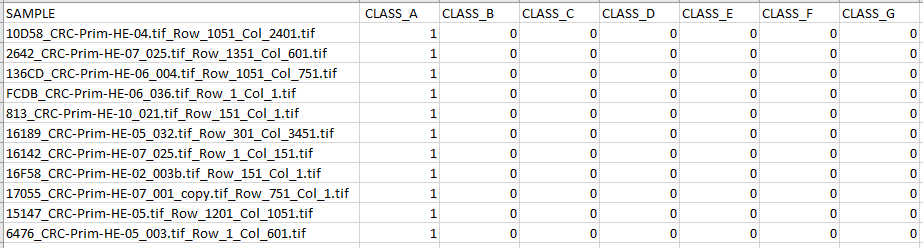

All the samples we can see in this snippet belong to class A.  

The ``data_loader`` would look like this:

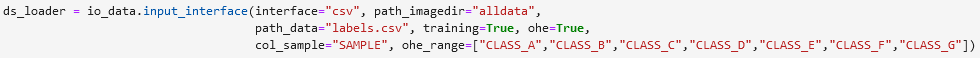

Since One Hot Encoding is true now, we need to tell ``AUCMEDI``, where to  find the One Hot Encoded Labels (``ohe_range``).  

But now let's continue with our loaded data from our csv-file with the sparse categorical labels. We can just continue as usual...  

This means, first defining a train, validation and test-set, then defining the model, training it and finally evaluating ist. If you have questions on these steps have a look in the corresponding notebooks.

## Continue as usual...

In [6]:
from aucmedi.sampling.split import sampling_split
train, validation, test = sampling_split(samples, class_ohe, sampling=[0.5, 0.25, 0.25], stratified=True, iterative=False, seed=123)

## Define the model

In [7]:
from aucmedi.neural_network.model import NeuralNetwork
import tensorflow_addons as tfa

f1Score = tfa.metrics.F1Score(num_classes=nclasses, threshold=0.5)

model = NeuralNetwork(n_labels=nclasses, channels=3, learning_rate=0.0001, 
                      loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], 
                      activation_output="softmax")

2022-07-20 11:58:25.748819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 11:58:26.324727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22844 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3f:00.0, compute capability: 7.5


## Train the model

In [8]:
from aucmedi.data_processing.data_generator import DataGenerator

train_generator = DataGenerator(samples=train[0], path_imagedir="alldata",
                                               resize=model.meta_input, standardize_mode=model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=None, 
                                               grayscale=False, subfunctions=[], prepare_images=False, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="alldata",
                                             resize=model.meta_input, standardize_mode=model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=False, 
                                             sample_weights=None, seed=123, workers=1)

history = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=None, class_weights=None, transfer_learning=False)

Epoch 1/20


2022-07-20 11:58:28.510173: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-20 11:58:29.077921: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


79/79 [==============================] - 16s 160ms/step - loss: 1.7033 - categorical_accuracy: 0.3492 - f1_score: 0.1203 - val_loss: 1.2974 - val_categorical_accuracy: 0.4784 - val_f1_score: 0.2314
Epoch 2/20
79/79 [==============================] - 12s 146ms/step - loss: 1.1149 - categorical_accuracy: 0.5640 - f1_score: 0.3746 - val_loss: 0.9872 - val_categorical_accuracy: 0.6072 - val_f1_score: 0.4384
Epoch 3/20
79/79 [==============================] - 11s 138ms/step - loss: 0.9008 - categorical_accuracy: 0.6480 - f1_score: 0.5499 - val_loss: 0.8457 - val_categorical_accuracy: 0.6880 - val_f1_score: 0.5363
Epoch 4/20
79/79 [==============================] - 12s 154ms/step - loss: 0.8302 - categorical_accuracy: 0.6812 - f1_score: 0.6103 - val_loss: 0.7538 - val_categorical_accuracy: 0.7336 - val_f1_score: 0.6227
Epoch 5/20
79/79 [==============================] - 11s 143ms/step - loss: 0.7418 - categorical_accuracy: 0.7196 - f1_score: 0.6740 - val_loss: 0.7097 - val_categorical_accura

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.validation.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


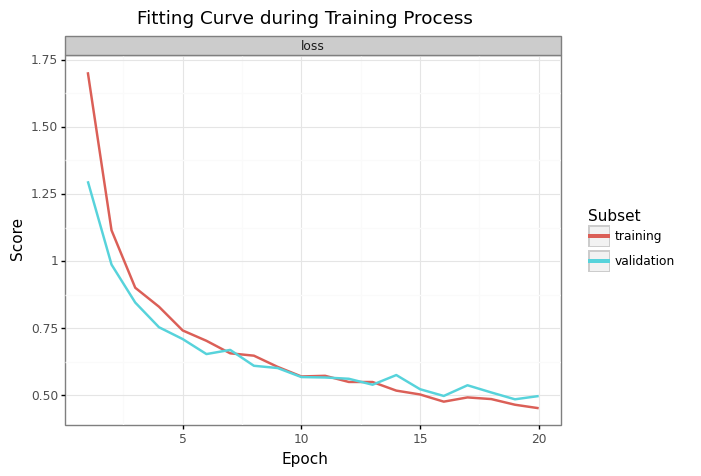

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.accuracy.png


/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


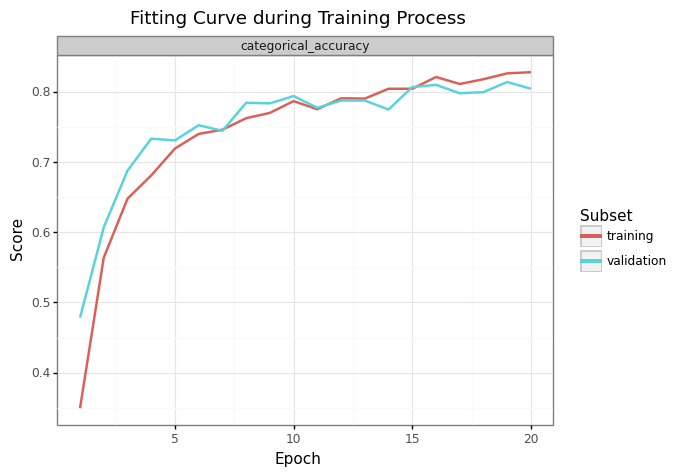

In [9]:
from aucmedi import *
from aucmedi.evaluation.fitting import *

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["loss"],
    prefix_split=".",
    suffix="validation",
    show=True
)

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["accuracy"],
    prefix_split=".",
    suffix="accuracy",
    show=True
)

In [10]:
from aucmedi.data_processing import data_generator

predict_generator = data_generator.DataGenerator(samples=test[0], path_imagedir="alldata",
                                                 resize=model.meta_input, standardize_mode=model.meta_standardize,
                                                 labels=None, image_format=image_format, batch_size=32, data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)

prediction = model.predict(prediction_generator=predict_generator)

40/40 [==============================] - 4s 95ms/step


/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.barplot.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

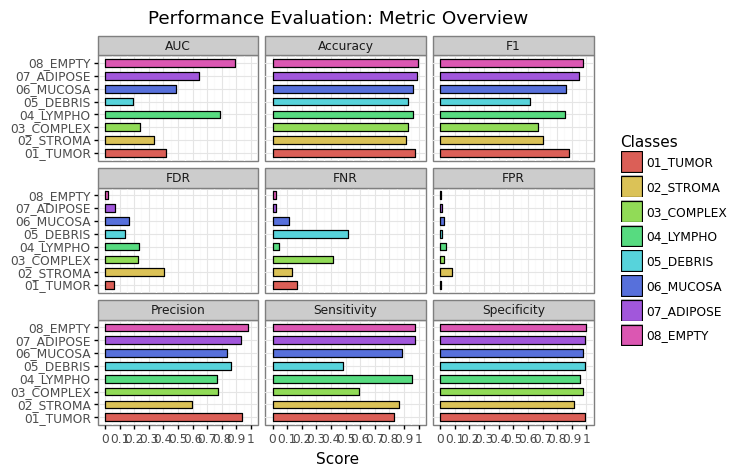

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.confusion_matrix.png


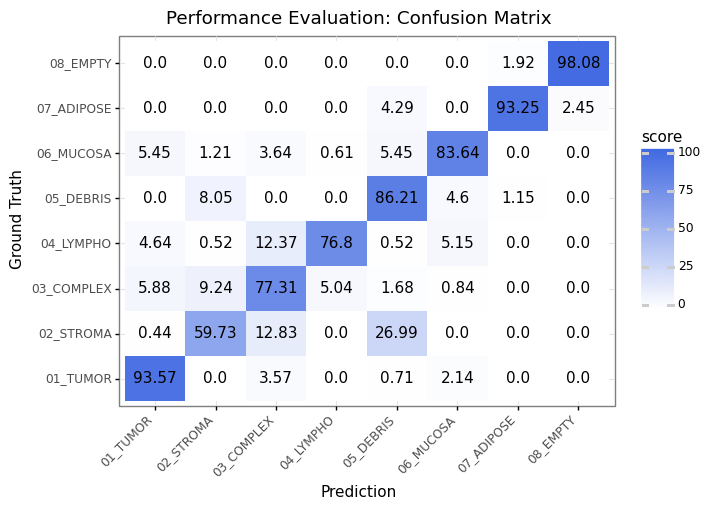

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:236: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.roc.png


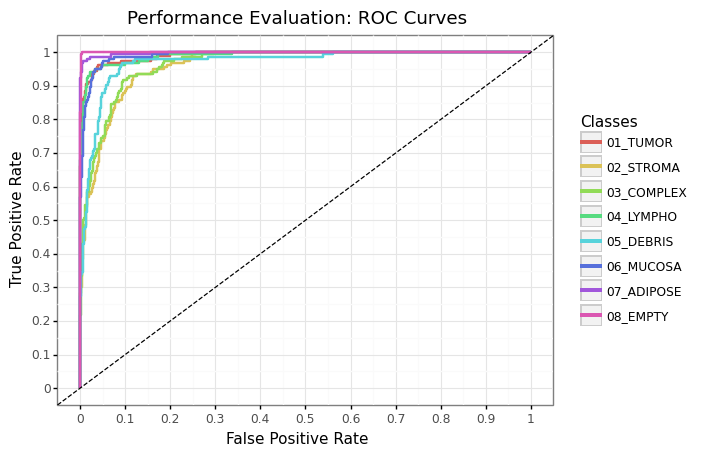

,metric,score,class
0,TP,131.000000,01_TUMOR
1,TN,1084.000000,01_TUMOR
2,FP,9.000000,01_TUMOR
3,FN,26.000000,01_TUMOR
4,Sensitivity,0.834395,01_TUMOR
...,...,...,...
99,FNR,0.025478,08_EMPTY
100,FDR,0.019231,08_EMPTY
101,Accuracy,0.994400,08_EMPTY
102,F1,0.977636,08_EMPTY


In [11]:
from aucmedi import *
from aucmedi.evaluation.performance import *

evaluate_performance(prediction, test[1], out_path="./", class_names=class_names, show=True)